L'objectif est sélectionné les features à utiliser sur la base des résultats obtenu avec un modèles de clustering fixé

In [1]:
!pip install kmodes


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.cm as cm
import pickle
import json
import seaborn as sns
from scipy.spatial import ConvexHull
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, BisectingKMeans, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import v_measure_score
from sklearn.metrics import make_scorer, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

# Fonctions

In [38]:
def reduce_to_2d_and_show(X,show=True,get_reduces=False):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    ts = TSNE(n_components=2)
    X_ts = ts.fit_transform(X)
    if show:
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3))
        ax1.scatter(X_pca[:,0],X_pca[:,1])
        ax1.set_title("Avec PCA")
        ax2.scatter(X_ts[:,0],X_ts[:,1])
        ax2.set_title("Avec TSNE")
        plt.suptitle("Nuage de points des données transformées",fontweight="bold")
        plt.show()
    if get_reduces:
        return X_pca, X_ts

def c_silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.silhouette_score(X, clusters)
    return score

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

def get_center_clusters(n_clusters, cluster_labels, X):
    center_clusters = []
    for i in range(n_clusters):
        points = X[cluster_labels == i]        
        x_mean = np.mean(points[:,0])
        y_mean = np.mean(points[:,1])
        c = centeroidnp(points)
        center_clusters.append(np.array(c))
    return np.array(center_clusters)

def show_inertie(data):
    min_clusters = 2
    max_clusters = 7
    inertie = []
    for k in range(min_clusters, max_clusters):
        kmeans = KMeans(n_clusters=k).fit(data)
        inertie.append(kmeans.inertia_)
    max_intertie = int(max(inertie))
    plt.figure(figsize=(10, 7))
    plt.plot(range(min_clusters, max_clusters), inertie, marker='+');
    plt.xlabel('Nombre de cluster')
    plt.ylabel('Inertie')
    plt.xticks(range(min_clusters,max_clusters))
    plt.show()

def show_cluster_content(n_clusters,dataframe,labels):
    vehicules_categorie = dataframe.copy()
    vehicules_categorie["categorie_label"] = labels
    vehicules_groups = vehicules_categorie.groupby("categorie_label")
    clusters_name = [f"Cluster {i}" for i in range(n_clusters)]
    #index = ["marques","noms","puissances","prix","longueurs","nbPlaces","nbPortes","bonus_malus","rejets_co2_gkm","cout_energie","nbVehicules"]
    index = ["marques","noms","puissances","prix","longueurs","nbPlaces","nbPortes","nbVehicules"]

    clusters_data = pd.DataFrame(index=index,columns=clusters_name)
    for i, vehicules_group in vehicules_groups:
        col = [] 
        col.append(str(vehicules_group.marque.unique()))
        col.append(str(vehicules_group.nom.unique()))
        col.append(f"{vehicules_group.puissance.min()}-{vehicules_group.puissance.max()}")
        col.append(f"{vehicules_group.prix.min()}-{vehicules_group.prix.max()}")
        col.append(str(vehicules_group.longueur.unique()))
        col.append(vehicules_group.nbPlaces.mode()[0])
        col.append(vehicules_group.nbPortes.mode()[0])
        #col.append(f"{vehicules_group.bonus_malus.min()}-{vehicules_group.bonus_malus.max()}")
        #col.append(f"{vehicules_group.rejets_co2_gkm.min()}-{vehicules_group.rejets_co2_gkm.max()}")
        #col.append(f"{vehicules_group.cout_energie.min()}-{vehicules_group.cout_energie.max()}")
        col.append(vehicules_group.shape[0])
        clusters_data.iloc[:,i] = col 
    display(clusters_data)

def show_cluster(config_name,n_clusters,X_train,estimator):
    # Réduction des dimensions
    pca = PCA(n_components=2)
    ts = TSNE(n_components=2)
    X_pca = pca.fit_transform(X_train)
    X_ts = ts.fit_transform(X_train)
    silhouette_score = metrics.silhouette_score(X_train, estimator.labels_, metric='euclidean')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(20, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_train) + (n_clusters + 1) * 10])
    cluster_labels = estimator.labels_
    nb_bad_sample = (sample_silhouette_values <= 0).sum()
    silhouette_score_ratio = int(silhouette_score * 100)
    
    sample_silhouette_values =  metrics.silhouette_samples(X_train, cluster_labels)
    nb_bad_sample = (sample_silhouette_values <= 0).sum()
    bad_sample_ratio = int((nb_bad_sample / sample_silhouette_values.shape[0]) * 100)
    
    print(f"{config_name} silhouette_score: {silhouette_score}")
    print(f"Taux de points mal classé: {bad_sample_ratio}%")
    print()
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title(f"{config_name} - Evaluation de la silhouette [score:{silhouette_score_ratio}|Taux points mals classés:{bad_sample_ratio}%]")
    ax1.set_xlabel("Coefficient de silhouette")
    ax1.set_ylabel("Label du cluster")
    ax1.axvline(x=silhouette_score, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)      
    center_clusters_pca = get_center_clusters(n_clusters, cluster_labels, X_pca)
    center_clusters_ts = get_center_clusters(n_clusters, cluster_labels, X_ts)
    # PCA
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
    ax2.scatter(center_clusters_pca[:, 0],center_clusters_pca[:, 1],marker="o",c="white",alpha=1,s=200,edgecolor="k")
    ax2.set_title(f"{config_name} - PCA Visualisation des données")
    for i, c in enumerate(center_clusters_pca):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    # TSNE
    ax3.scatter(X_ts[:, 0], X_ts[:, 1], c=colors)
    ax3.scatter(center_clusters_ts[:, 0],center_clusters_ts[:, 1],marker="o",c="white",alpha=1,s=200,edgecolor="k")
    ax3.set_title(f"{config_name} - TSNE Visualisation des données")
    for i, c in enumerate(center_clusters_ts):
        ax3.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    plt.show()

In [39]:
# Chargement des données

In [42]:
catalogue = pd.read_csv("data/Catalogue.csv", encoding='latin-1')

Les données qu'on utilise sont composés de variables numériques et catégorielle par conséquent au opteplus pour des modèles de cluster permettant de travailler ces variables. On fixe KModeMixed pour l'instant car il permet de faire du KMeans sur des données numérique et non numérique en même temps.

# Données

In [58]:
X = catalogue[catalogue.prix < catalogue.prix.quantile(0.995)]

In [59]:
models = []

In [60]:
""" Fonction de scoring """
def custom_silhouette_scorer(estimator, X):      
    labels = estimator.predict(X)
    score = silhouette_score(X, labels)
    return score

# Experience Kmeans

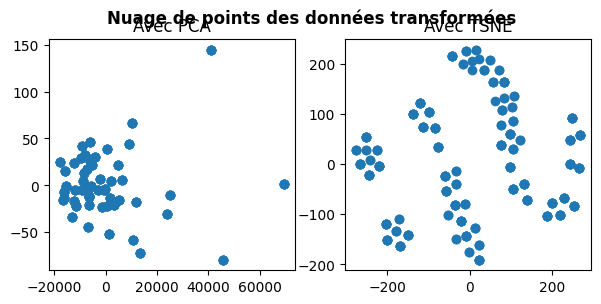

265
Configuration: 	 KMeans(init='random', max_iter=100, n_clusters=5, n_init=2, random_state=3)
Score: 		 0.6889193781327663
Paramètres: 	 {'init': 'random', 'max_iter': 100, 'n_clusters': 5, 'n_init': 2, 'random_state': 3, 'tol': 0.0001}
Kmeans: L'indice de silhouette est : 0.6232868795422378
kmeans silhouette_score: 0.6232868795422378
Taux de points mal classé: 0%



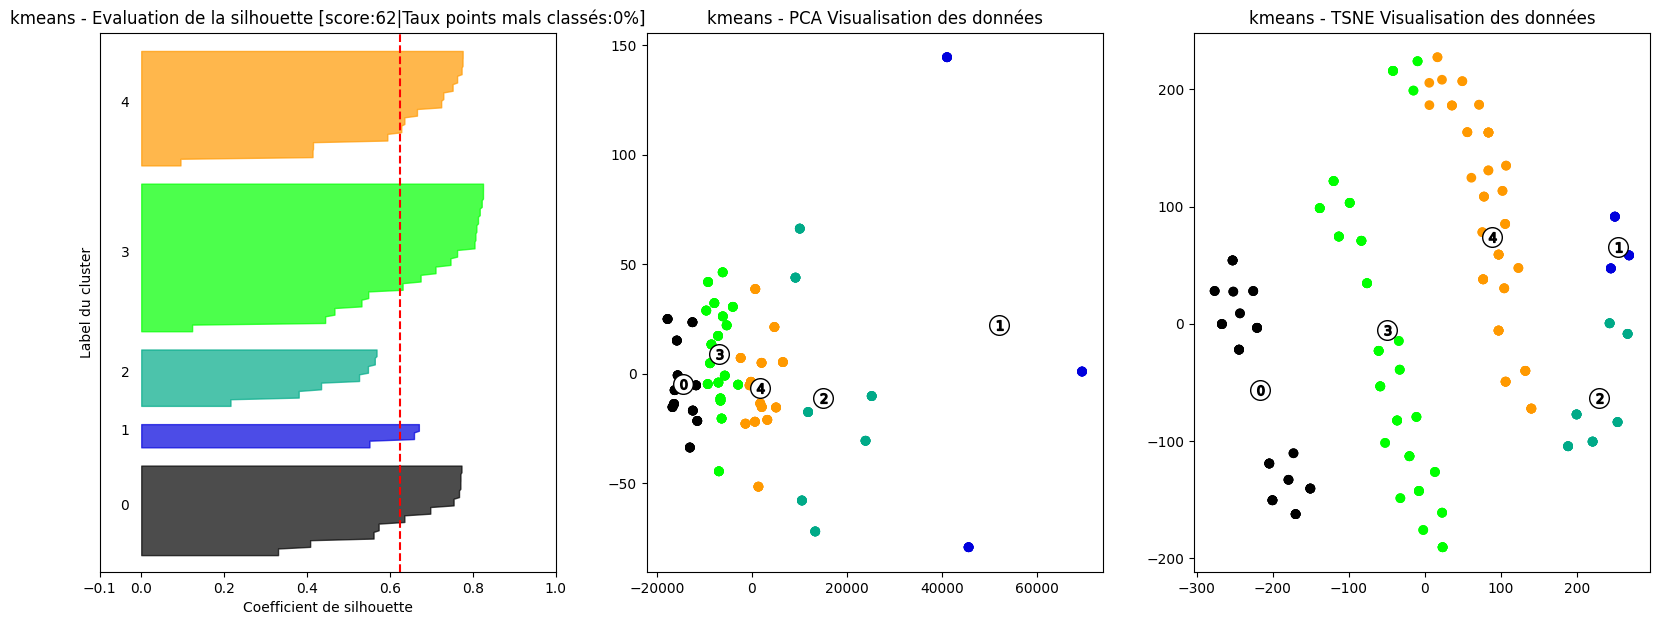

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
marques,['Volkswagen' 'Peugeot' 'Mini' 'Lancia' 'Kia' ...,['Mercedes' 'BMW'],['Volvo' 'Saab' 'Renault' 'Jaguar' 'BMW'],['Volkswagen' 'Seat' 'Renault' 'Nissan' 'Mini'...,['Volkswagen' 'Skoda' 'Saab' 'Renault' 'Nissan...
noms,['Polo 1.2 6V' '1007 1.4' 'Copper 1.6 16V' 'Yp...,['S500' 'M5'],['S80 T6' '9.3 1.8T' 'Vel Satis 3.5 V6' 'X-Typ...,['Touran 2.0 FSI' 'New Beatle 1.8' 'Golf 2.0 F...,['Touran 2.0 FSI' 'New Beatle 1.8' 'Golf 2.0 F...
puissances,55-115,306-507,150-272,75-170,110-200
prix,7500-13750,66360-94800,34440-50500,15644-22350,22900-31790
longueurs,['courte' 'moyenne'],['très longue'],['très longue' 'longue' 'moyenne'],['longue' 'moyenne' 'courte'],['longue' 'moyenne' 'très longue']
nbPlaces,5,5,5,5,5
nbPortes,5,5,5,5,5
nbVehicules,55,15,35,90,70


In [61]:
##### Definition des features
selector_features = ["prix","puissance"]
onehot_features = ['longueur']
binarizer_features = ["nbPortes","nbPlaces","occasion"] 

##### Definition des transformeurs
numeric_transformer = Pipeline(steps=[('scaler', preprocessing.StandardScaler())])
onehot_transformer = Pipeline(steps=[('onehot', preprocessing.OneHotEncoder())])
binarizer_transformer = Pipeline(steps=[('binarizer', preprocessing.Binarizer())])

#### Definition de la pipeline de transformation
tranformaters = ColumnTransformer(
    transformers=[
        ('scaler_transform',"passthrough",selector_features),
        ('onehot_transform', onehot_transformer, onehot_features),
        ('binarize_transform', binarizer_transformer, binarizer_features)
    ])

#### Definition de la pipeline
k_means_pipeline = Pipeline(steps=[('tranformations', tranformaters)])

#### fit de la pipeline
k_means_pipeline.fit(X)

#### Transformation des données
X_train = k_means_pipeline.transform(X)

### Visualisation des données
#display(pd.DataFrame(X_train).head(1))
reduce_to_2d_and_show(X_train)

#### Grille paramètre
param_grid = {
    "n_clusters":[4,5],
    "random_state": range(5),
    "init":["random","k-means++"],
    "n_init": ["auto",1,2,3,4],
    'max_iter': [100, 300, 500],
    'tol': [0.0001, 0.001, 0.01],
}

#### Entrainement
kmeans = KMeans()
grid = GridSearchCV(kmeans,param_grid=param_grid,cv=4,scoring=custom_silhouette_scorer)
grid.fit(X_train)

print(len(grid.best_estimator_.labels_))

#### Evaluation
silhouette_avg = silhouette_score(X_train,grid.best_estimator_.labels_) 

#### Résultats
print(f"Configuration: \t",grid.best_estimator_)
print(f"Score: \t\t",grid.best_score_)
print(f"Paramètres: \t",grid.best_params_)
print("Kmeans: L'indice de silhouette est :", silhouette_avg)

#### Visualisation
show_cluster("kmeans",grid.best_params_["n_clusters"],X_train,grid.best_estimator_)
show_cluster_content(grid.best_params_["n_clusters"],X,grid.best_estimator_.labels_)

In [62]:
#### Enregisrement du modèle
models.append(["kmeans",grid.best_score_,silhouette_avg,str(grid.best_params_)])

# Experience 4 avec K-prototype

,0,1,2,3,4,5
0,1.561398,1.318696,3.0,5,5,False


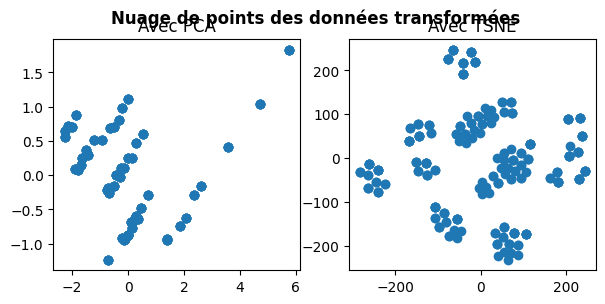

Configuration: 	 KPrototypes(gamma=1.0, n_clusters=5)
Score: 		 0.3418816366737832
Paramètres: 	 {'n_clusters': 5, 'gamma': 1.0, 'n_init': 10, 'max_iter': 100}
kproto: L'indice de silhouette est : 0.3418816366737832
kproto silhouette_score: 0.3418816366737832
Taux de points mal classé: 7%



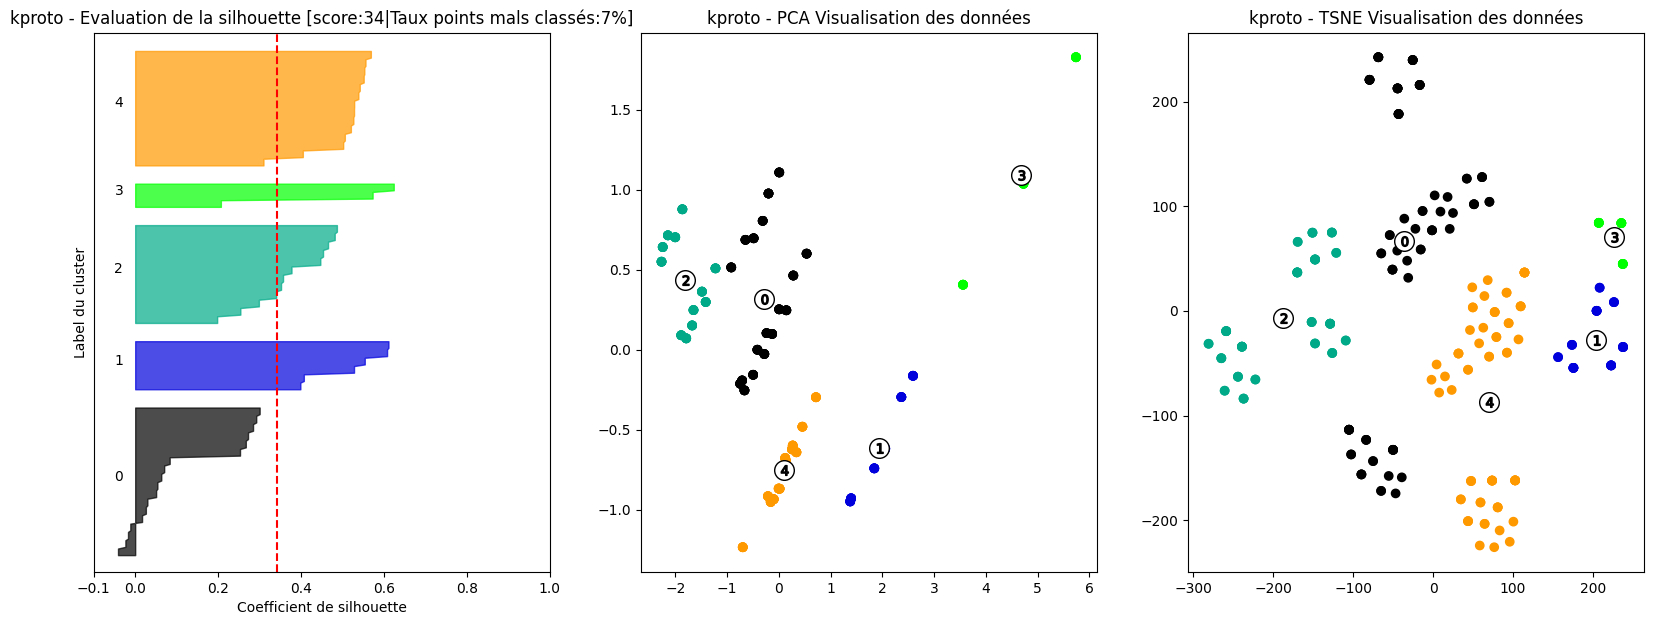

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
marques,['Volkswagen' 'Seat' 'Saab' 'Renault' 'Nissan'...,['Volvo' 'Skoda' 'Renault' 'Nissan'],['Volkswagen' 'Peugeot' 'Mini' 'Lancia' 'Kia' ...,['Mercedes' 'BMW'],['Volkswagen' 'Renault' 'Nissan' 'Mercedes' 'D...
noms,['Touran 2.0 FSI' 'Toledo 1.6' '9.3 1.8T' 'Lag...,['S80 T6' 'Superb 2.8 V6' 'Vel Satis 3.5 V6' '...,['Polo 1.2 6V' '1007 1.4' 'Copper 1.6 16V' 'Yp...,['S500' 'M5'],['New Beatle 1.8' 'Golf 2.0 FSI' 'Megane 2.0 1...
puissances,102-197,193-272,55-115,306-507,90-150
prix,15960-38600,30000-50500,8540-18310,66360-94800,7500-35800
longueurs,['longue'],['très longue'],['courte'],['très longue'],['moyenne']
nbPlaces,5,5,5,5,5
nbPortes,5,5,5,5,5
nbVehicules,90,30,60,15,70


In [63]:
##### Definition des features
numeric_features = ["prix","puissance"]
label_features = ['longueur']
cat_features = ["nbPortes","nbPlaces","occasion"] 

##### Definition des transformeurs
numeric_transformer = Pipeline(steps=[('scaler', preprocessing.StandardScaler())])
label_transformer = Pipeline(steps=[('labeler', preprocessing.OrdinalEncoder())])


#### Definition de la pipeline de transformation
tranformaters = ColumnTransformer(
    transformers=[
        ('numeric_transform',numeric_transformer,numeric_features),
        ('label_transform', label_transformer, label_features),
        ('select', "passthrough", cat_features)
    ])

#### Definition de la pipeline
kprototype_pipeline = Pipeline(steps=[('tranformations', tranformaters)])

#### fit de la pipeline
kprototype_pipeline.fit(X)

#### Transformation des données
X_train = kprototype_pipeline.transform(X)

### Visualisation des données
display(pd.DataFrame(X_train).head(1))
reduce_to_2d_and_show(X_train)

#### Grille paramètre
param_grid = {
    'n_clusters': [4,5],
    'gamma': [0.1, 0.5, 1.0, 2.0, 5.0],
    'n_init': [5, 10, 15, 20],
    'max_iter': [50, 100, 200],
}

categorical_index = [2,3,4,5]

#### Entrainement
best_score = -1
best_model = None
best_params = None

for n_clusters in param_grid['n_clusters']:
    for gamma in param_grid['gamma']:
        for n_init in param_grid['n_init']:
            for max_iter in param_grid['max_iter']:
                kproto = KPrototypes(n_clusters=n_clusters, init='Cao',gamma=gamma, n_init=n_init, max_iter=max_iter)
                kproto.fit(X_train, categorical=categorical_index)
                labels = kproto.labels_
                sil_score = silhouette_score(X_train, labels)
                if sil_score > best_score:
                    best_score = sil_score
                    best_model = kproto
                    best_params =  {
                    'n_clusters': n_clusters,
                    'gamma': gamma,
                    'n_init': n_init,
                    'max_iter': max_iter
                }

#### Evaluation
silhouette_avg = silhouette_score(X_train,best_model.labels_) 

#### Résultats
print(f"Configuration: \t",best_model)
print(f"Score: \t\t",best_score)
print(f"Paramètres: \t",best_params)
print("kproto: L'indice de silhouette est :", silhouette_avg)

#### Visualisation
show_cluster("kproto",best_params["n_clusters"],X_train,best_model)
show_cluster_content(best_params["n_clusters"],X,best_model.labels_)

In [64]:
models.append(["kprototype",best_score,silhouette_avg,str(best_params)])

# Experience avec agglomerativeClustering

In [65]:
def agglo_silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.silhouette_score(X, clusters)
    return score

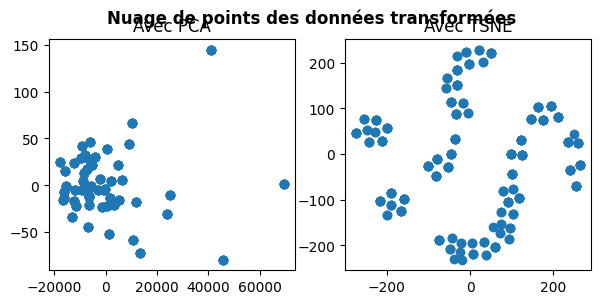

Configuration: 	 AgglomerativeClustering(linkage='complete', metric='euclidean', n_clusters=5)
Score: 		 0.724522465094921
Paramètres: 	 {'linkage': 'complete', 'metric': 'euclidean', 'n_clusters': 5}
Kmeans: L'indice de silhouette est : 0.6019460748281417
agglomerative-clustering silhouette_score: 0.6019460748281417
Taux de points mal classé: 5%



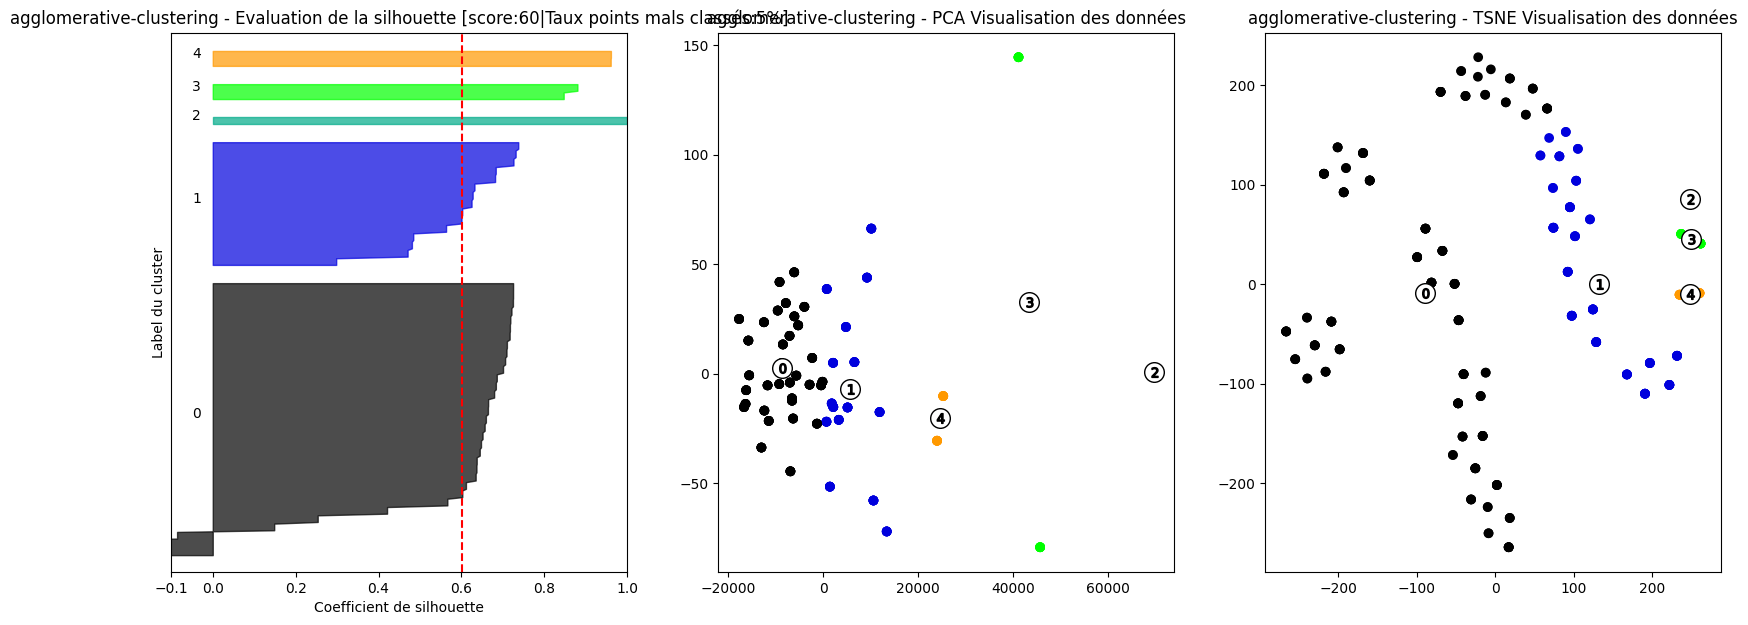

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
marques,['Volkswagen' 'Seat' 'Renault' 'Peugeot' 'Niss...,['Volvo' 'Volkswagen' 'Skoda' 'Saab' 'Renault'...,['BMW'],['Mercedes' 'BMW'],['Volvo' 'Renault']
noms,['Touran 2.0 FSI' 'Polo 1.2 6V' 'New Beatle 1....,['S80 T6' 'Touran 2.0 FSI' 'New Beatle 1.8' 'S...,['M5'],['S500' 'M5'],['S80 T6' 'Vel Satis 3.5 V6']
puissances,55-170,110-272,507-507,306-507,245-272
prix,7500-25060,25900-38600,94800-94800,66360-70910,49200-50500
longueurs,['longue' 'courte' 'moyenne'],['très longue' 'longue' 'moyenne'],['très longue'],['très longue'],['très longue']
nbPlaces,5,5,5,5,5
nbPortes,5,5,5,5,5
nbVehicules,165,75,5,10,10


In [66]:
##### Definition des features
selector_features = ["prix","puissance"]
label_features = ['longueur']
selector_features2 = ["nbPortes","nbPlaces","occasion"] 

##### Definition des transformeurs
label_transformer = Pipeline(steps=[('binarizer', preprocessing.OrdinalEncoder())])

#### Definition de la pipeline de transformation
tranformaters = ColumnTransformer(
    transformers=[
        ('selector', "passthrough", selector_features),
        ('label_transform',label_transformer,label_features),
        ('selector2', "passthrough", selector_features2),
    ])

#### Definition de la pipeline
agglo_pipeline = Pipeline(steps=[('tranformations', tranformaters)])

#### fit de la pipeline
agglo_pipeline.fit(X)

#### Transformation des données
X_train = agglo_pipeline.transform(X)

### Visualisation des données
#display(pd.DataFrame(X_train).head(1))
reduce_to_2d_and_show(X_train)

#### Grille paramètre
param_grid = {
    'n_clusters': [4,5],
    'linkage': ['complete', 'average', 'single'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

#### Entrainement
agglo = AgglomerativeClustering()
grid = GridSearchCV(agglo,param_grid=param_grid,cv=4,scoring=agglo_silhouette_score)
grid.fit(X_train)

#### Evaluation
silhouette_avg = silhouette_score(X_train,grid.best_estimator_.labels_) 

#### Résultats
print(f"Configuration: \t",grid.best_estimator_)
print(f"Score: \t\t",grid.best_score_)
print(f"Paramètres: \t",grid.best_params_)
print("Kmeans: L'indice de silhouette est :", silhouette_avg)

#### Visualisation
show_cluster("agglomerative-clustering",grid.best_params_["n_clusters"],X_train,grid.best_estimator_)
show_cluster_content(grid.best_params_["n_clusters"],X,grid.best_estimator_.labels_)

In [67]:
models.append(["agglomerative-clustering",grid.best_score_,silhouette_avg,str(grid.best_params_)])

# Experience avec GaussianMixture

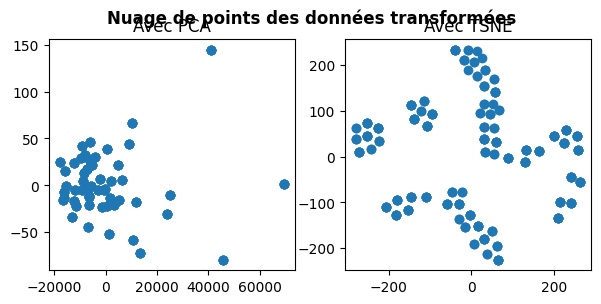

C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_10456\1041137980.py", line 4, in custom_silhouette_scorer
    score = silhouette_score(X, labels)
  File "C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 117, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "C:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 231, in silhouette_samples
    check_number_of_

Configuration: 	 GaussianMixture(covariance_type='spherical', max_iter=200, n_components=4)
Score: 		 0.643435505616854
Paramètres: 	 {'covariance_type': 'spherical', 'init_params': 'kmeans', 'max_iter': 200, 'n_components': 4}
GaussianMixture: L'indice de silhouette est : 0.5133131077123818
gaussian-mixture silhouette_score: 0.5133131077123818
Taux de points mal classé: 1%



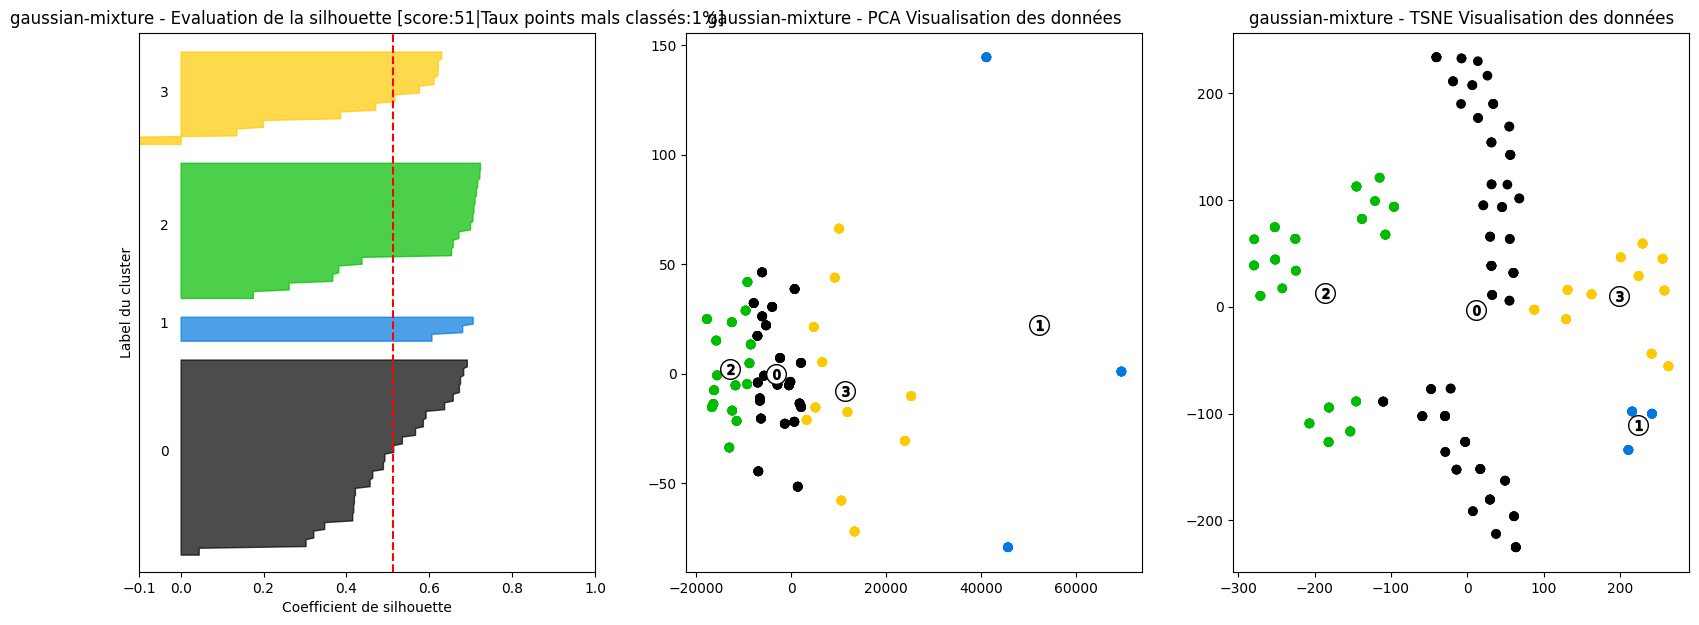

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
marques,['Volkswagen' 'Seat' 'Saab' 'Renault' 'Nissan'...,['Mercedes' 'BMW'],['Volkswagen' 'Renault' 'Peugeot' 'Nissan' 'Mi...,['Volvo' 'Skoda' 'Saab' 'Renault' 'Nissan' 'Ja...
noms,['Touran 2.0 FSI' 'New Beatle 1.8' 'Golf 2.0 F...,['S500' 'M5'],['Polo 1.2 6V' 'Golf 2.0 FSI' 'Megane 2.0 16V'...,['S80 T6' 'Superb 2.8 V6' '9.3 1.8T' 'Vel Sati...
puissances,75-197,306-507,55-150,150-272
prix,17346-27340,66360-94800,7500-16730,28500-50500
longueurs,['longue' 'moyenne' 'courte'],['très longue'],['courte' 'moyenne' 'longue'],['très longue' 'longue' 'moyenne']
nbPlaces,5,5,5,5
nbPortes,5,5,5,5
nbVehicules,115,15,80,55


In [68]:
##### Definition des features
numeric_features = ["prix","puissance"]
categorical_features = ['longueur',"nbPortes","nbPlaces","occasion"] 

##### Definition des transformeurs
onehot_transformer = Pipeline(steps=[('onehot', preprocessing.OneHotEncoder())])


#### Definition de la pipeline de transformation
tranformaters = ColumnTransformer(
    transformers=[
        ('numeric_transform', "passthrough", numeric_features),
        ('onhot_transform',onehot_transformer,categorical_features)
    ]
)


#### Definition de la pipeline
gmm_pipeline = Pipeline(steps=[('tranformations', tranformaters)])

#### fit de la pipeline
gmm_pipeline.fit(X)

#### Transformation des données
X_train = gmm_pipeline.transform(X)

### Visualisation des données
#display(pd.DataFrame(X_train).head(1))
reduce_to_2d_and_show(X_train)

#### Grille paramètre
param_grid = {
    'n_components': [4,5],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'init_params': ['kmeans', 'random'],
    'max_iter': [50, 100, 200],
}


#### Entrainement
gmm = GaussianMixture()
grid = GridSearchCV(gmm,param_grid=param_grid,cv=4,scoring=custom_silhouette_scorer)

grid.fit(X_train)

clusters = grid.best_estimator_.predict(X_train)

grid.best_estimator_.labels_ = clusters

#### Evaluation
silhouette_avg = silhouette_score(X_train,grid.best_estimator_.labels_) 

#### Résultats
print(f"Configuration: \t",grid.best_estimator_)
print(f"Score: \t\t",grid.best_score_)
print(f"Paramètres: \t",grid.best_params_)
print("GaussianMixture: L'indice de silhouette est :", silhouette_avg)

#### Visualisation
show_cluster("gaussian-mixture",grid.best_params_["n_components"],X_train,grid.best_estimator_)
show_cluster_content(grid.best_params_["n_components"],X,grid.best_estimator_.labels_)

In [69]:
models.append(["gaussian-mixture",grid.best_score_,silhouette_avg,str(grid.best_params_)])

# Résultats

In [70]:
models_results_df = pd.DataFrame(models,columns=["modele","train_silhouette_score","test_silhouette_score","params"])
models_results_df.to_csv("cluster_models_results.csv")
models_results_df.sort_values(["test_silhouette_score"],ascending=False)

,modele,train_silhouette_score,test_silhouette_score,params
0,kmeans,0.688919,0.623287,"{'init': 'random', 'max_iter': 100, 'n_cluster..."
2,agglomerative-clustering,0.724522,0.601946,"{'linkage': 'complete', 'metric': 'euclidean',..."
3,gaussian-mixture,0.643436,0.513313,"{'covariance_type': 'spherical', 'init_params'..."
1,kprototype,0.341882,0.341882,"{'n_clusters': 5, 'gamma': 1.0, 'n_init': 10, ..."


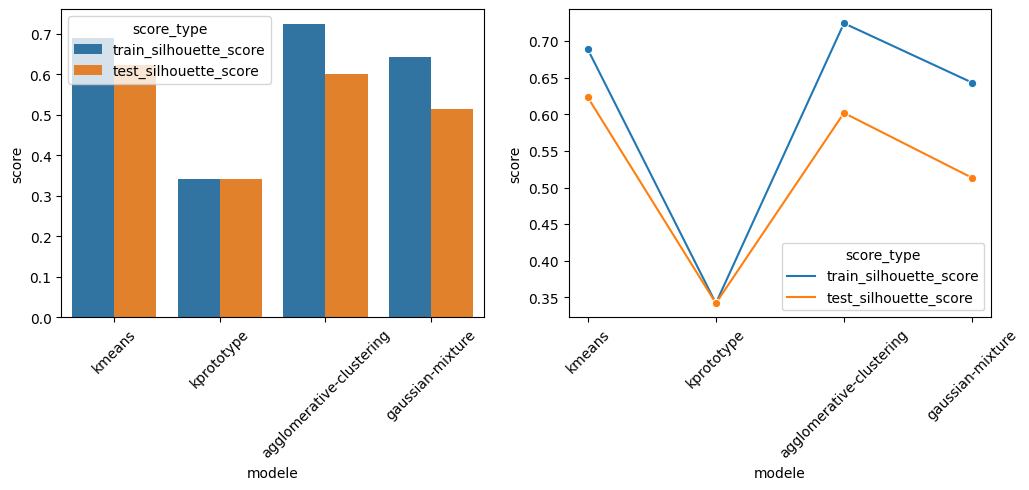

In [71]:
df_scores = models_results_df.melt(id_vars=["modele","params"],var_name='score_type', value_name='score')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

sns.barplot(data=df_scores, x='modele', y='score', hue='score_type',ax=ax1)
sns.lineplot(data=df_scores, x='modele', y='score', hue='score_type',marker='o',ax=ax2)

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

for tick in ax2.get_xticklabels():
    tick.set_rotation(45)


plt.show()

- le train_score le plus élevé vient de l'AgglomerativeClustering mais sont train_score est plus élevé que son test_score. Cela est certainement dû à un surentrainement. Il est trop précis sur son jeu d'entrainement et il s'adapte mal aux autres données

- le train_score de Kprototype est le plus faible mais son test_score plus élévé que celui. Ce contraste est difficile à expliquer mais certainement cela est dû au fait qu'il n'a pas eu assez de données pour être entrainer par conséquent nous ne somme pas sur de sa précision sur dans gransd volume de données

- gaussian-mixture à un train_score et un test_score équilibiré. De plus son test_score est le deuxième plus élévé. Par conséquent on a un modèle qui pourrait bien gérer les nouvelles données tout en réduisant ses erreurs.

- Kmean à le deuxième train_score le plus élevé et le test_score le plus élévé. Le gap entre le train et le test étant mince on peut dire qu'il pourra bien gérer les nouvelles données et avec son test_score on a le modèle avec le moins d'erreur. Par conséquent il serait l'idéal pour notre cas. 

On se propose quand-même d'observer la composition de ses clusters et celui du gaussian-mixture pour être fixé. On a remarque que guaussian-mixture reparti trop bien les véhicules tandis que kmeans réparti aussi bien mais à des erreurs prêts et est plus nuancé. Par conséquent on opte pour Kmeans pour la suite car les données des véhicules sont par nature inter-inclusif et serait donc mieux d'opter pour modèle qui gére bien cette notion